Stress test:
- There are 5531452 rows in the csv file in total (including header)
- It takes 3m31s to read train_data.csv

In [1]:
# N = sum(1 for line in open('data/train_data.csv'))
# N
# print(sum(1 for line in open('data/train_labels.csv')))

In [2]:
# df = pd.read_csv('data/train_data.csv')
# labels = pd.read_csv('data/train_labels.csv')

## Setup

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

This reads the entire train csv (too much compute needed, I will work with a smaller sample)
```
features = pd.read_csv('data/train_data.csv')
labels = pd.read_csv('data/train_labels.csv')
```

This prints how many customers have a number of data points
```
data_points = features.groupby('customer_ID').count()
for i in range(14):
    print(i, len(data_points['S_2'].loc[data_points['S_2'] == i]))
```
From the results, most customers have 13 data points by a large margin

#### Overview of the data: 
- 190 columns in total
- 'S_2' is the credit card statement date
- 'customer_ID' is the customer ID, each ID has multiple entries to account for each credit card statement
- 'D_63': ['CR' 'CO' 'CL' 'XZ' 'XM' 'XL']
- 'D_64': ['O' 'R' nan 'U' '-1']
- 'B_31': [0 1]
- The rest of the columns are floats
- 122/190 columns have null values

code below:

```
features.dtypes.unique()
```
<sup>array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)</sup>
```
obj_cols = features.select_dtypes(include=['O']).columns
obj_cols
```
<sup>Index(['customer_ID', 'S_2', 'D_63', 'D_64'], dtype='object')</sup>
```
int_cols = features.select_dtypes(include=['int64']).columns
int_cols
```
<sup>Index(['B_31'], dtype='object')</sup>
```
print('B_31', features.B_31.unique())
for col in obj_cols.drop(['customer_ID', 'S_2']):
    print(col, features[col].unique())
```
<sup>B_31 [1 0]
D_63 ['CR' 'CO' 'CL' 'XZ' 'XM' 'XL']
D_64 ['O' 'R' nan 'U' '-1']</sup>
```
float_cols = features.select_dtypes(include=['float64']).columns
float_cols
```
<sup>Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
       'D_43',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=185)</sup>
```
# features with NaN data points
nullcols = []
for col in features:
    if features[col].isnull().values.any():
        nullcols.append(col)
len(nullcols)
```
<sup>122</sup>

#### Generate distribution histograms of the columns:

In [4]:
###
# features.hist(bins=20, figsize=(60, 40))
###

From the histograms, there are a few features with unusual distributions. Notable distributions include singular values, binary, and discrete features. The following function gets the binary features:

In [5]:
from mlxtend.preprocessing import minmax_scaling

def get_binary_cols(features):
    obj_cols = features.select_dtypes(include=['O', '<M8[ns]'])
    scaled_data = minmax_scaling(features.drop(obj_cols, axis=1), columns=features.drop(obj_cols, axis=1).columns)
    binary_cols = []
    for cname in scaled_data:
        cmean = scaled_data[cname].mean()
        if len(scaled_data.loc[(0.01 < scaled_data[cname]) & (scaled_data[cname] < 0.99)]) == 0:
            binary_cols.append(cname)
    return binary_cols


## Preprocessing

#### Useful utility functions:

In [6]:
def get_sample(features, size):
    # gets (size) amount of customers
    prng = np.random.RandomState(0)
    g = features.groupby('customer_ID')

    portion = features[g.ngroup().isin(prng.choice(g.ngroups, size, replace=False))]
    return portion

# sample1 = get_sample(len(labels)//100)
# sample2 = get_sample(1000)
sample1 = pd.read_csv('data/sample1.csv').set_index('sampled_index')

In [7]:
# exports data
# sample1.to_csv('./data/sample1.csv')

In [8]:
def get_y(ids):
    label_lookup = dict()
    for id in ids:
        if id not in label_lookup:
            target = labels.loc[labels.customer_ID == id, 'target']
            label_lookup[id] = target.iloc[0]

    return pd.Series([label_lookup[id] for id in ids], index=ids)
    # for id in features.customer_ID.unique():
    #     if len(features.loc[features.customer_ID == id, 'target'].unique()) != 1:
    #         print(features.loc[features.customer_ID == id])
    
# sample_y = get_y(sample1['customer_ID'])
labels = pd.read_csv('data/sample1_labels.csv')

In [9]:
# exports data
# sample_y.to_csv('./data/sample1_labels.csv')

In [10]:
sample1['S_2'] = pd.to_datetime(sample1['S_2'], format='%Y-%m-%d')

In [11]:
print(len(sample1.columns))
len(sample1)

190


55393

#### Data Imputation:

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

# custom transformer
class FloatImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
        
    def fill_group(self, group, col_defaults):
        for cname in group.columns:
            if group[cname].isna().all():
                group[cname].fillna(col_defaults[cname], inplace=True)

    def fit(self, X: pd.DataFrame, y = None):
        self.fitted_imputers = {}
        col_defaults = {cname : 0.0 for cname in X.columns}
        def fit_group(group: pd.DataFrame):
            self.fill_group(group, col_defaults)
            imp = SimpleImputer()
            self.fitted_imputers[group.index[0]] = imp.fit(group)
        X.groupby(X.index).apply(fit_group)
        return self
        
    def transform(self, X: pd.DataFrame, y = None):
        col_defaults = {cname : X[cname].mean() for cname in X.columns}
        def transform_group(group: pd.DataFrame):
            self.fill_group(group, col_defaults)
            return pd.DataFrame(self.fitted_imputers[group.index[0]].transform(group))
        transformed = X.groupby(X.index).apply(transform_group)
        return transformed.reset_index().set_index('customer_ID').drop('level_1', axis=1).set_axis(X.columns, axis=1)

In [13]:
def impute_X(data: pd.DataFrame):
    data = data.set_index('customer_ID')

    discrete_cols = data.select_dtypes(['object', 'int64'])
    for cname in discrete_cols.columns:
        discrete_cols[cname], _ = discrete_cols[cname].factorize()

    float_cols = data.select_dtypes('float64')
    imputer = FloatImputer()
    float_cols = imputer.fit_transform(float_cols)

    data = pd.concat([data[['S_2']], float_cols, discrete_cols], axis=1)
    discretes = (data.dtypes == 'int64')

    return data, discretes

imputed, discretes = impute_X(sample1)

d:\Users\jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
binary_cols = get_binary_cols(sample1)
print(binary_cols[:10], len(binary_cols))

['R_2', 'S_6', 'R_4', 'D_66', 'R_15', 'S_18', 'D_86', 'D_87', 'B_31', 'R_19'] 34


## Feature engineering

#### Mutual Information:

relatively informative: 

In [15]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discretes=False):
    mi_scores = mutual_info_classif(X, y, discrete_features=discretes)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [16]:
imputed_y = get_y(imputed.index)
mi_scores = make_mi_scores(imputed.drop('S_2', axis=1), imputed_y, discretes.drop('S_2'))
mi_scores.head(5)

D_77    0.224307
P_2     0.212303
D_48    0.175764
D_61    0.160905
B_17    0.152091
Name: MI Scores, dtype: float64

relatively uninformative:

In [17]:
mi_scores.tail(5)

S_18     0.0
R_18     0.0
R_23     0.0
D_96     0.0
D_109    0.0
Name: MI Scores, dtype: float64

discrete features:

In [18]:
mi_scores.loc[discretes]

D_64    0.019079
D_63    0.003451
B_31    0.001955
Name: MI Scores, dtype: float64

In [19]:
# Histograms of the top 20 mi scores: 
# features[mi_scores.head(20).index].hist(bins=20, figsize=(21, 14))

#### Principal Components: 

In [20]:
from sklearn.decomposition import PCA

def make_pca(pca_features):
    pca_scaled = (pca_features - pca_features.mean(axis=0)) / pca_features.std(axis=0)

    pca = PCA()
    X_pca = pca.fit_transform(pca_features)

    column_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns = column_names)

    return pca, X_pca

floats = (imputed.dtypes == 'float64')
pca_cnames = floats.loc[floats == True].index
# pca_cnames = ['B_16', 'B_32', 'D_65', 'D_77', 'P_2']
pca_features = imputed.loc[:, pca_cnames]
pca, X_pca = make_pca(pca_features)

In [21]:
pca_mi = make_mi_scores(X_pca, imputed_y, False)
pca_mi.head(5)

PC2    0.167977
PC3    0.155502
PC5    0.138809
PC1    0.131823
PC4    0.114340
Name: MI Scores, dtype: float64

Above indicates that the principal component axes are not as informative as the features themselves, which might be because there are no better alternative representation of the data than the original features.

In [22]:
components = pd.DataFrame(pca.components_.T, columns = X_pca.columns, index = pca_features.columns)
components.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC176,PC177,PC178,PC179,PC180,PC181,PC182,PC183,PC184,PC185
P_2,0.000296,-0.004905,-0.013600,0.029331,-0.029722,-0.017754,0.063560,0.001619,-0.032743,-0.057510,...,-0.000592,-0.000712,-0.001054,0.000072,-0.000664,0.000152,-0.000140,-0.000164,-0.000064,-0.000000e+00
D_39,-0.000199,0.001505,0.005591,-0.004144,0.020799,0.023364,-0.019937,0.001781,-0.007330,-0.048633,...,-0.000278,-0.001949,0.000101,0.000040,-0.000051,0.000065,-0.000069,0.000027,0.000068,2.443524e-17
B_1,-0.000287,0.000981,0.009333,-0.016605,0.022780,0.017451,-0.064635,-0.013176,-0.015857,0.005405,...,0.086873,0.638114,-0.001885,0.002510,0.000621,-0.000318,-0.000482,0.001452,-0.000717,-2.275557e-16
B_2,0.000748,-0.003225,-0.021510,0.043722,-0.055609,-0.045751,0.139457,0.027727,0.024414,-0.071891,...,0.000726,0.004494,0.000132,0.000523,-0.000266,0.000072,-0.000244,-0.000074,-0.000022,-6.221602e-17
R_1,-0.000185,0.006376,0.004856,-0.014275,0.016440,0.011899,-0.037282,0.025234,0.009621,0.029470,...,0.001012,-0.000348,0.000384,0.000120,0.000429,0.000119,0.000242,-0.000327,-0.000152,3.061342e-17


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D229528198>,
      dtype=object)

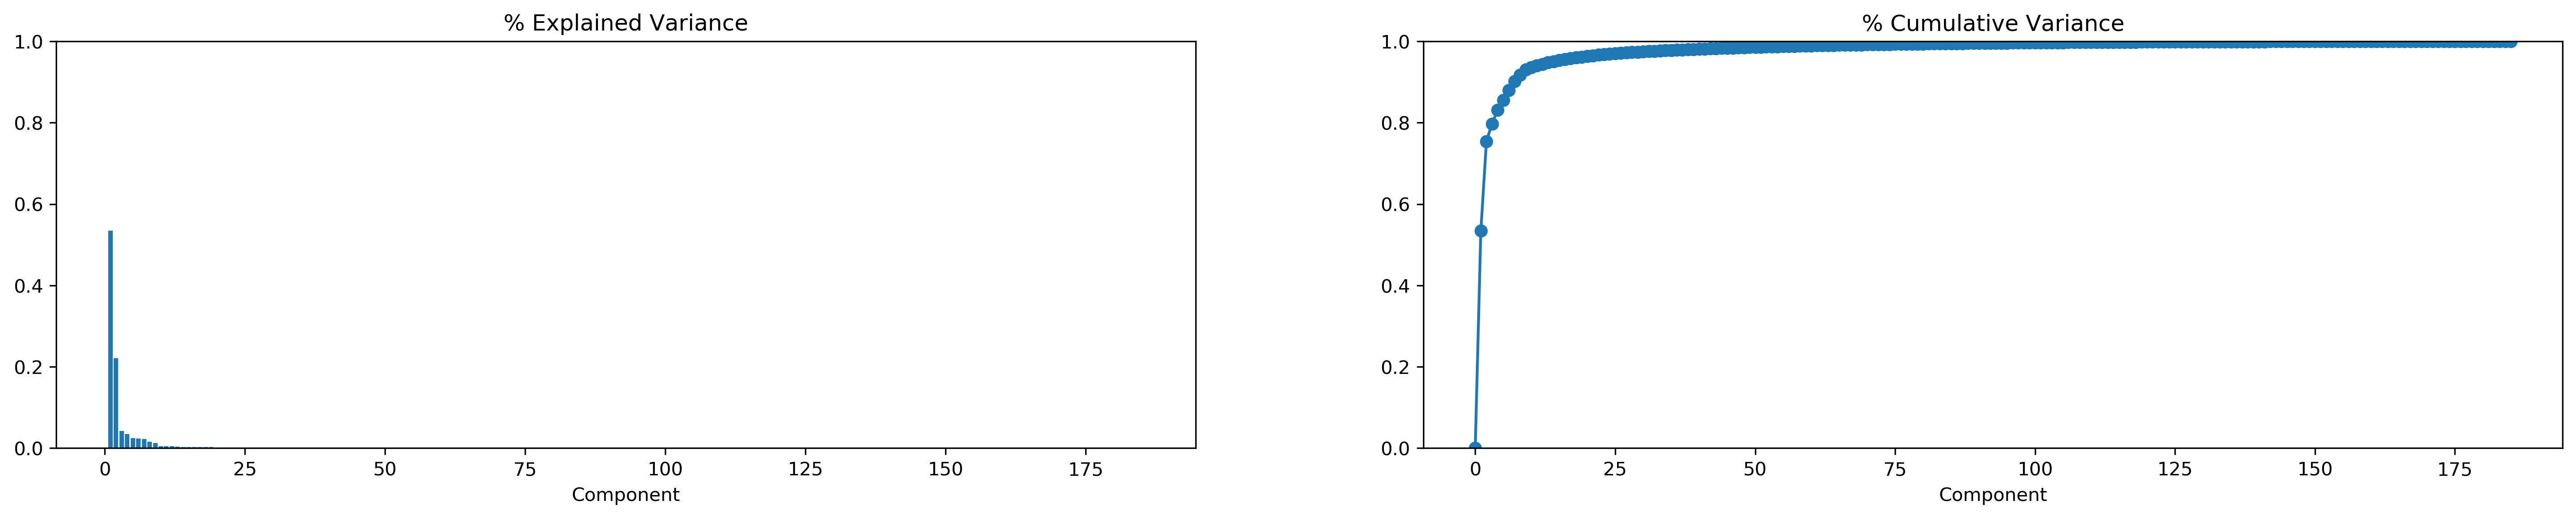

In [23]:
import matplotlib.pyplot as plt

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=width, dpi=dpi)
    return axs

plot_variance(pca, 24, 300)

% explained variance tapers off before component 25

Check for features with strong correlations with each other:

In [24]:
# a baseline for looking at PCA component values
baseline = 1/152
baseline

0.006578947368421052

In [25]:
selected_components = components[[f'PC{i}' for i in range(1, 26)]]
corr_df = pd.DataFrame()
for cname in selected_components.columns:
    temp = []
    for i in range(len(selected_components)):
        val = selected_components[cname].iloc[i]
        if -baseline > val or baseline < val:
            temp.append(val)
        else:
            temp.append(pd.NA)
    corr_df[cname] = temp

corr_df.columns = selected_components.columns
corr_df.index = selected_components.index
corr_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
P_2,<NA>,<NA>,-0.0135999,0.0293311,-0.0297218,-0.0177538,0.0635604,<NA>,-0.0327427,-0.0575105,...,-0.0558614,0.0124997,<NA>,-0.0244463,0.0478967,0.0344434,0.0195174,0.033109,-0.0632001,0.0222468
D_39,<NA>,<NA>,<NA>,<NA>,0.0207986,0.0233639,-0.0199369,<NA>,-0.00732951,-0.0486329,...,0.0832845,0.00792454,-0.0299466,-0.00896149,0.0172112,-0.0115626,-0.0376966,0.0737016,0.177627,<NA>
B_1,<NA>,<NA>,0.0093326,-0.0166051,0.02278,0.0174514,-0.0646347,-0.0131759,-0.0158574,<NA>,...,-0.0189165,0.0863009,0.0111829,0.0275094,0.0833032,<NA>,-0.0888636,0.0551135,-0.11382,0.0904857
B_2,<NA>,<NA>,-0.0215095,0.0437215,-0.0556088,-0.0457508,0.139457,0.0277274,0.0244145,-0.0718907,...,0.0591834,-0.153168,-0.00883931,-0.0492347,-0.121246,<NA>,0.164014,-0.108434,-0.0350095,0.0954455
R_1,<NA>,<NA>,<NA>,-0.014275,0.0164397,0.011899,-0.0372824,0.0252338,0.0096212,0.0294696,...,0.10324,-0.0922653,-0.0573959,0.0230737,-0.0122563,-0.0259293,-0.0088399,<NA>,0.0161362,0.0557409


A few features with relatively significant correlation:

In [26]:
corr_df.loc[corr_df['PC1'].notna(), 'PC1']

B_10    0.999988
Name: PC1, dtype: object

In [27]:
corr_df.loc[(corr_df['PC2'].notna()) & (abs(corr_df['PC2']) > 0.1), 'PC2']

R_14    0.997014
Name: PC2, dtype: object

In [28]:
corr_df.loc[(corr_df['PC3'].notna()) & (abs(corr_df['PC3']) > 0.1), 'PC3']

B_40    0.9916
Name: PC3, dtype: object

In [29]:
corr_df.loc[(corr_df['PC4'].notna()) & (abs(corr_df['PC4']) > 0.1), 'PC4']

D_68     0.104158
B_38    -0.165662
D_117    0.959071
Name: PC4, dtype: object

In [30]:
corr_df.loc[(corr_df['PC5'].notna()) & (abs(corr_df['PC5']) > 0.1), 'PC5']

D_69    0.869755
B_26    0.358112
B_38    0.243654
Name: PC5, dtype: object

Seems like many of PCs are just reflective of the variations of one feature, so there isn't much correlation between the original features

#### KMeans:

In [31]:
hi_mi = mi_scores.head(100).index

cat_extend = binary_cols + ['D_63', 'D_64']
f = hi_mi.isin(cat_extend)
hi_mi_cats = []
for i in range(len(hi_mi)):
    if f[i]:
        hi_mi_cats.append(hi_mi[i])
hi_mi_cats

['B_33', 'D_135', 'D_137', 'R_2', 'D_127']

Clustering on binary and categorical features:

In [32]:
from sklearn.cluster import KMeans

# kmeans_cnames = mi_scores.head(20).index
# kmeans = KMeans(n_clusters=30, n_init=20, random_state=0) # 0.1959

# kmeans_cnames = mi_scores.head(50).loc[mi_scores.isin(binary_cols)].index
# kmeans = KMeans(n_clusters=30, n_init=20, random_state=0)

# kmeans_cnames = mi_scores.head(50).loc[~mi_scores.isin(binary_cols)].index
# kmeans = KMeans(n_clusters=20, n_init=20)

kmeans_cnames = hi_mi_cats
kmeans = KMeans(n_clusters=32, n_init=20, random_state=0)

cluster = pd.DataFrame()
cluster['Cluster'] = kmeans.fit_predict(imputed.loc[:, kmeans_cnames])
cluster['Cluster'] = cluster['Cluster'].astype('category')

In [33]:
cluster_mi_score = make_mi_scores(cluster, imputed_y, [True])
cluster_mi_score.head()

Cluster    0.142594
Name: MI Scores, dtype: float64

In [34]:
s1_clustered = sample1.copy()
s1_clustered['cluster'] = cluster['Cluster']

Averaging the features of each customer deterioates MI scores

## Supervised learning

#### Strategy:
- for each customer, do linear regression on a select few features with time as independent variable (with as few basis vectors as possible to avoid increasing dimensions)
- train an xgb classifier based on the coefficients from the linear model

In [35]:
g = s1_clustered.groupby('customer_ID')
X_train, X_test = s1_clustered[g.ngroup() <= 4000], s1_clustered[g.ngroup() > 4000]
y_train, y_test = get_y(X_train.customer_ID), get_y(X_test.customer_ID)

In [36]:
# a line plot of the features of 10 arbitrary customers

# plotting = sample1.drop('customer_ID', axis=1).drop(mi_scores.tail(150).index, axis=1)
# id_sample = sample1.customer_ID.sample(10)

# for id in id_sample:
#     sample1.set_index('S_2').drop(mi_scores.tail(150).index, axis=1).loc[sample1.set_index('S_2')['customer_ID'] == id].drop('customer_ID', axis=1).plot(subplots=True, layout=(9, 6), figsize=(30, 20))

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

class LinRegTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, ids, dates):
        # Assuming the dates column is sorted from earlier to later for each customer_ID, and there are no missing values
        self.ids = ids
        self.dates = dates
    def fit(self, X, y=None):
        # X is the column modeled by linear regression
        working = pd.DataFrame(self.dates).set_index(self.ids).set_axis(['time'], axis=1)
        self.fitted_models = {}
        def fit_models(group):
            scaler = MinMaxScaler(feature_range=(0, 1))
            time = scaler.fit_transform((group['time'] - group['time'].iloc[0]).dt.days.values.reshape(-1, 1)).reshape(1, -1)[0]
            regX = pd.DataFrame()
            for i in range(11):
                regX[f'poly{i}'] = time ** i
            model = LinearRegression(fit_intercept=False)
            model.fit(regX, group)
            self.fitted_models[group.index[0]] = model
        working.groupby(working.index).apply(fit_models)
        return self
    def transform(self, X, y=None):
        uniques = self.ids.unique()
        
        # This sets up the shape of the dataframe
        sample_coefs = self.fitted_models[uniques[0]].coef_[0]
        ret = pd.DataFrame(columns=[f'{X.name}_coef{i}' for i in range(len(sample_coefs))])
        for i in range(len(uniques)):
            ret.loc[uniques[i]] = self.fitted_models[uniques[i]].coef_[0]
        return ret

In [38]:
list(mi_scores.head(10).index)

['D_77', 'P_2', 'D_48', 'D_61', 'B_17', 'D_62', 'D_44', 'B_9', 'D_75', 'B_18']

In [91]:
class IDMeanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, id_name = None):
        self.id_name = id_name
    def fit(self, X, y = None):
        return self
    def transform(self, X: pd.DataFrame, y = None):
        transformed = X.groupby(X.index if self.id_name == None else self.id_name).apply(lambda df: df.mean())
        return transformed

In [105]:
def preprocess_floats(data: pd.DataFrame):
    # preprocess(data) is the preprocessed float columns
    # data is the complete feature set with customer_ID as its index
    float_cols = data.select_dtypes('float64')
    imputer = FloatImputer()
    float_cols = imputer.fit_transform(float_cols)
    return float_cols

def preprocess_cats(data: pd.DataFrame):
    # preprocess(data) is the preprocessed categorical columns
    # data is the complete feature set with customer_ID as its index
    discrete_cols = data.select_dtypes(exclude='float64')
    for cname in discrete_cols.columns:
        discrete_cols[cname], _ = discrete_cols[cname].factorize()
    return discrete_cols

def preprocess(data: pd.DataFrame):
    data = data.set_index('customer_ID')
    selected_features = ['D_77', 'P_2', 'D_48', 'D_61', 'B_17', 'D_62', 'D_44', 'B_9', 'D_75', 'B_18']
    selected_data = data[selected_features]

    cats = preprocess_cats(selected_data)
    floats = preprocess_floats(selected_data)

    columns = [data[['S_2']], cats, floats]

    return pd.concat(columns, axis=1)

def encode(data: pd.DataFrame):
    # assumes data was preprocessed
    linreg = LinRegTransformer(data.index, data['S_2'])
    floats = data.select_dtypes('float64')
    cats = data.select_dtypes(['object', 'int64', 'category'])

    columns = []
    for cname in floats.columns:
        regressed = linreg.fit_transform(floats[cname])
        columns.append(regressed)

    # mean encode the categoricals
    folder = IDMeanTransformer()
    for cname in cats.columns:
        folded = folder.fit_transform(cats[cname])
        columns.append(folded)
    
    return pd.concat(columns, axis=1)

def preprocess_encode(data: pd.DataFrame):
    data = data.set_index('customer_ID')
    selected_features = ['D_77', 'P_2', 'D_48', 'D_61', 'B_17', 'D_62', 'D_44', 'B_9', 'D_75', 'B_18']
    selected_data = data[selected_features]

    cats = preprocess_cats(selected_data)
    floats = preprocess_floats(selected_data)

    # linear regression encode the floats
    linreg = LinRegTransformer(data.index, data['S_2'])
    columns = []
    for cname in floats.columns:
        regressed = linreg.fit_transform(floats[cname])
        columns.append(regressed)

    # mean encode the categoricals
    folder = IDMeanTransformer()
    for cname in cats.columns:
        folded = folder.fit_transform(cats[cname])
        columns.append(folded)
    
    return pd.concat(columns, axis=1)

X_train_preprocessed = preprocess(X_train)
X_train_input = encode(X_train_preprocessed)

X_train_input.head()

,D_77_coef0,D_77_coef1,D_77_coef2,D_77_coef3,D_77_coef4,D_77_coef5,D_77_coef6,D_77_coef7,D_77_coef8,D_77_coef9,...,B_18_coef1,B_18_coef2,B_18_coef3,B_18_coef4,B_18_coef5,B_18_coef6,B_18_coef7,B_18_coef8,B_18_coef9,B_18_coef10
001404030d4c78b76bf02e809387611bdf6b708a42c5890ecc057970b51bff87,1.488672e+18,3.360960e+16,2.565700e+05,-1.816988e+06,7.808834e+06,-2.154467e+07,3.899897e+07,-4.606362e+07,3.417261e+07,-1.444566e+07,...,3.360960e+16,2.565700e+05,-1.816988e+06,7.808834e+06,-2.154467e+07,3.899897e+07,-4.606362e+07,3.417261e+07,-1.444566e+07,2.652799e+06
001cdb20ffadc532a456ed4d8af7f8d6b9e1924dc867440d6b79e0eb6dd60739,1.490227e+18,2.989440e+16,3.359280e+05,-2.318440e+06,9.728517e+06,-2.623882e+07,4.652441e+07,-5.395510e+07,3.940028e+07,-1.643341e+07,...,2.989440e+16,3.359280e+05,-2.318440e+06,9.728517e+06,-2.623882e+07,4.652441e+07,-5.395510e+07,3.940028e+07,-1.643341e+07,2.984285e+06
001f781c7913e962b9fcb8e7001663f0a31e0646b857f0f57643942de49d80a5,1.499558e+18,2.246399e+16,1.609989e+11,-1.108286e+12,3.989124e+12,-7.921757e+12,7.764353e+12,-6.681950e+11,-6.185331e+12,5.554126e+12,...,2.246399e+16,1.609989e+11,-1.108286e+12,3.989124e+12,-7.921757e+12,7.764353e+12,-6.681950e+11,-6.185331e+12,5.554126e+12,-1.575584e+12
00252a52c9d997f25742e8d4e026cda5b1b94d33a850e3b2dd13de2609c31e6c,1.489536e+18,3.136320e+16,7.435500e+05,-5.297762e+06,2.292723e+07,-6.373527e+07,1.163198e+08,-1.386015e+08,1.037759e+08,-4.429200e+07,...,3.136320e+16,7.435500e+05,-5.297762e+06,2.292723e+07,-6.373527e+07,1.163198e+08,-1.386015e+08,1.037759e+08,-4.429200e+07,8.213957e+06
0045a4494de5cfcbd98839d3df2f28e30fad352a59c2d997cf23e5fabdad977b,1.488326e+18,3.386880e+16,9.236080e+05,-6.743168e+06,2.973689e+07,-8.383568e+07,1.545131e+08,-1.852650e+08,1.391828e+08,-5.947067e+07,...,3.386880e+16,9.236080e+05,-6.743168e+06,2.973689e+07,-8.383568e+07,1.545131e+08,-1.852650e+08,1.391828e+08,-5.947067e+07,1.102286e+07


In [93]:
from xgboost import XGBClassifier

my_model = XGBClassifier()
my_model.fit(X_train_input, get_y(X_train_input.index))

d:\Users\jason\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=True, validate_parameters=1, verbosity=None)

In [94]:
X_test_input = preprocess_encode(X_test)
predictions = my_model.predict(X_test_input)
len(predictions) == len(X_test.customer_ID.unique())

d:\Users\jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


True

In [95]:
actual_y = get_y(X_test_input.index.unique())

In [96]:
def score(predictions, actual):
    print(f'Proportions correct: {(predictions == actual).sum()/len(predictions)}')
    
    total_score = 0
    actual_score = 0
    for i in range(len(actual)):
        if actual[i] == 0:
            total_score += 20
            actual_score += 20 if predictions[i] == actual[i] else 0
        else:
            total_score += 1
            actual_score += 1 if predictions[i] == actual[i] else 0
    print(f'Proportion of total score: {actual_score/total_score}')

score(predictions, actual_y)

Proportions correct: 0.7125850340136054
Proportion of total score: 0.8752056146507292


Proportions correct: 0.6955782312925171

Proportion of total score: 0.8532733852396096